# Evaluación y reentrenamiento de un modelo en particular

*Programa que entrena la red neuronal con los datos reducidos de las señales y las distribuciones de probabilidad*

*Tiene como salida lcm y σ con las que fueron generadas*

*Se utiliza el método K-Folds para prevenir el overfitting de la red neuronal*

*Autor: Juan Pablo Morales*

In [1]:
# Importamos las librerias necesarias
using Flux
using Statistics
using Flux: train!
using Plots
using DataFrames
using CSV
using StatsPlots
using LaTeXStrings
using LinearAlgebra
using PlotlyJS
using CUDA
using Random
using Measures

┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means that you will not be able to save figures using `savefig`.
│ 
│ If you are on Windows this might be caused by known problems with Kaleido v0.2 on Windows (you are using version 0.2.1).
│ You might want to try forcing a downgrade of the Kaleido_jll library to 0.1.
│ Check the Package Readme at https://github.com/JuliaPlots/PlotlyKaleido.jl/tree/main#windows-note for more details.
│ 
│ If you think this is not your case, you might try using a longer timeout to check if the process is not responding (defaults to 10 seconds) by passing the desired value in seconds using the `timeout` kwarg when calling `PlotlyKaleido.start` or `PlotlyKaleido.restart`
└ @ PlotlyKaleido C:\Users\Propietario\.julia\packages\PlotlyKaleido\uMRVG\src\PlotlyKaleido.jl:24


In [2]:
# Importamos los parámetros del experimento
include("../1-GeneracionDatos/Parameters.jl");

In [3]:
# Distribucion de probabilidad log-normal que se puede agregar a la función costo de la red neuronal, lleva mucho tiempo de entrenamiento

function Pln(lcm, σ)
    return [(exp(-(log(lc) - log(lcm))^2 / (2σ^2))) / (lc * σ * sqrt(2π)) for lc in lcs]
end

####################################################################################################################
# Funciones de pre procesamiento para escalar los datos y estandarizarlos

# Normalización Max-Min
function MaxMin(data)
    min_vals = minimum(data, dims=1)
    max_vals = maximum(data, dims=1)
    scaled_data = (data .- min_vals) ./ (max_vals .- min_vals)
    return scaled_data

end

# Estandarización Z
function Standarize(data)
    mean_vals = mean(data, dims=1)
    std_devs = std(data, dims=1)
    standardized_data = (data .- mean_vals) ./ std_devs
    return standardized_data
end

####################################################################################################################
# Metricas de validacion de la red neuronal, solo utilice RMAE

# Root Mean Squared Error
function RMSE(predicted, real)
    return sqrt(Flux.mse(predicted, real))
end

# Mean Absolute Error
function MAE(predicted, real)
    return sum(abs.(predicted .- real)) / length(predicted)
end

# R2 score
function R2_score(predicted, real)
    return 1 - sum((predicted .- real).^2) / sum((real .- mean(real)).^2)
end

# Realetive Root Mean Squared Error
function RRMSE(predicted, real)
    return sqrt(mean((predicted .- real).^2)) / mean(real)
end

# Relative Mean Absolute Error
function RMAE(predicted, real)
    return mean(abs.(predicted .- real)) / mean(real)
end

# Mean Absolute Percentaje Error
function MAPE(predicted, real)
    return mean(abs.((predicted .- real) ./ real))
end

####################################################################################################################

# Regularizaciones L1 y L2
pen_l2(x::AbstractArray) = Float32.(sum(abs2, x) / 2)
pen_l1(x::AbstractArray) = Float32.(sum(abs, x) / 2)

####################################################################################################################

# Funciones de pre procesamiento para escalar los datos y estandarizarlos

# Normalización Max-Min
function MaxMin(data)
    min_vals = minimum(data, dims=1)
    max_vals = maximum(data, dims=1)
    scaled_data = (data .- min_vals) ./ (max_vals .- min_vals)
    return scaled_data

end

# Estandarización Z
function Standarize(data)
    mean_vals = mean(data, dims=1)
    print(mean_vals)
    std_devs = std(data, dims=1)
    print(std_devs)
    standardized_data = (data .- mean_vals) ./ std_devs
    return standardized_data
end;

In [4]:
# Leemos los datos de las señales en PCA
path_read = "../1-GeneracionDatos/Data/"
df_datasignals = CSV.read("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-2-Autoencoders/Models/ReducedDataNLData.csv", DataFrame)

Row,component1,component2,component3,sigma,lcm
,Float64,Float64,Float64,Float64,Float64
1,-2.79422,-0.750164,-0.40166,0.01,0.5
2,-2.79693,-0.751604,-0.401917,0.02,0.5
3,-2.80042,-0.753716,-0.402205,0.03,0.5
4,-2.80524,-0.756672,-0.402591,0.04,0.5
5,-2.81134,-0.760471,-0.403059,0.05,0.5
6,-2.81865,-0.765112,-0.403591,0.06,0.5
7,-2.82708,-0.770591,-0.404157,0.07,0.5
8,-2.83653,-0.776904,-0.40473,0.08,0.5
9,-2.8469,-0.784046,-0.405273,0.09,0.5


## K-folds

Utilizamos la técnica de validación cruzada K-Folds para prevenir el overfitting de la red neuronal. La técnica consiste en dividir el conjunto de datos en K subconjuntos, y se entrena el modelo K veces, cada vez utilizando un subconjunto diferente como conjunto de validación y el resto como conjunto de entrenamiento. Al final se promedian los resultados obtenidos en cada iteración. Esto nos permite tener una mejor estimación de como funcionará el modelo con datos que no ha visto antes.

La manera de separar los datos que realizo es la siguiente:
1. Se dividen los datos en K subconjuntos de igual tamaño.
2. Estos conjuntos se dividen de manera que se mantenga una porción representativa de los datos en cada una, por esto se toman señales correspondientes a $\sigma$ y $l_{cm}$, se empieza con $l_{cm}$ de 0.5 y se inicia con un $\sigma$ entre 0.01 y 0.05, luego se van dando saltos equiespaciados de 0.05 en 0.05 hasta llegar a 0.5, luego se pasa al siguiente $l_{cm}$ y se repite el proceso.
3. Este último paso nos da conjuntos disjuntos de señales que se utilizan para entrenar y validar el modelo.

In [9]:
# Utilizamos la técnica k-fold de validación cruzada para prevenir el overfitting de la red neuronal
# Definimos el número de folds
folds = 5
percent_valid = 0.2
step_valid = Int(1 / percent_valid)
num_datos = Int(size(df_datasignals, 1))

# Guardamos los datos de validacion de cada NN en cada fold
out_of_sample_data = []
out_of_sample_pred = []

# Guardamos la metrica de validación de cada NN en cada fold
scores_RMSE = []

# Definimos desde donde empezamos los datos de testing
idx_startTest = 6

# Primero sacamos los datos de testing de los datos de señales, estos seran un 3er conjunto de datos que no se usara para entrenar ni validar la red
df_datasignals_out = df_datasignals[idx_startTest:step_valid:num_datos,:]
# Datos de Testing
df_datasignals_minus_out = df_datasignals[setdiff(1:num_datos, idx_startTest:step_valid:num_datos),:]
# Nuevo numero de datos que tenemos para entrenamiento + validacion
num_datos_new = Int(size(df_datasignals_minus_out, 1))

4481

In [ ]:
# Método de K-Folds

for k in 1:folds
    # Usamos 5 conjuntos disjuntos de datos de validación del 5% total de los datos para cada fold

    datasignals_valid = Float32.(Matrix(df_datasignals_minus_out[k^2 + 10:step_valid:num_datos_new,1:3])')
    datasignals = Float32.(Matrix(df_datasignals_minus_out[setdiff(1:num_datos_new, k^2 + 10:step_valid:num_datos_new),1:3])')

    σ_valid = df_datasignals_minus_out[k^2 + 10:step_valid:num_datos_new,4]
    lcm_valid = df_datasignals_minus_out[k^2 + 10:step_valid:num_datos_new,5]
    
    σ_col = df_datasignals_minus_out[setdiff(1:num_datos_new, k^2 + 10:step_valid:num_datos_new),4]
    lcm_col = df_datasignals_minus_out[setdiff(1:num_datos_new, k^2 + 10:step_valid:num_datos_new),5]
    
    dataparams = hcat(lcm_col, σ_col)'
    dataparams_valid = hcat(lcm_valid, σ_valid)'

    # Uno de los modelos que dio buenos resultados en la exploración anterior
    # 16,"[3, 32, 64, 32, 16, 2]",tanh,ADAM,0.0,None,0,0.017810457567638147,0.01427131790632415

    id = 17

    # Definimos la red neuronal
    model = Chain(
        Dense(3, 32),
        Dense(32, 64, tanh_fast),
        Dense(64, 32, tanh_fast),
        Dense(32, 16, tanh_fast),
        Dense(16, 2, softplus),
    )

    # Cargamos los parámetros del modelo
    path = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Params/017_params.csv"

    p, re = Flux.destructure(model)
    
    theta = CSV.read(path, DataFrame)
    p = @views Float32.(theta[:,1])

    # Función de loss
    function loss(x,y)
        return Flux.mse(re(p)(x), y)
    end

    # Definimos el metodo de aprendizaje y la tasa de aprendizaje
    η = 1e-4
    opt = ADAM(η)

    # Definimos el número de épocas
    epochs = 5000

    # Definimos el tamaño del batch
    batch_size = 100

    # Usamos dataloader para cargar los datos
    data = Flux.DataLoader((datasignals, dataparams), batchsize = batch_size, shuffle = true)
    data_valid = Flux.DataLoader((datasignals_valid, dataparams_valid), batchsize = batch_size, shuffle = true)

    # Definimos una funcion de callback para ver el progreso del entrenamiento
    global iter = 0
    cb = function()
        global iter += 1
        if iter % length(data) == 0
            epoch = iter ÷ length(data)
            if epoch % 500 == 0
                actual_loss = loss(data.data[1], data.data[2])
                actual_valid_loss = loss(data_valid.data[1], data_valid.data[2])
                println("Epoch $epoch || Loss = $actual_loss || Valid Loss = $actual_valid_loss")
            end
        end
    end;

    # Entrenamos la red neuronal con el loss mse variando la tasa de aprendizaje cada 500 épocas
    for epoch in 1:epochs
        Flux.train!(loss, Flux.params(p), data, opt, cb=cb)
        if epoch % 500 == 0
            η = η * 0.2
            opt = ADAM(η)
        end
    end

    # Predicción de la red en la validacion
    predictions_valid = re(p)(datasignals_valid)

    # Métricas de validación de la red
    RMSE_valid = RMSE(predictions_valid, dataparams_valid)

    push!(scores_RMSE, RMSE_valid)

    # Guardamos los datos de validación y las predicciones de la red
    push!(out_of_sample_data, dataparams_valid)
    push!(out_of_sample_pred, predictions_valid)

    println("Fold $k terminado con score de validación RMSE = $RMSE_valid")

end

In [ ]:
#Ahora sacamos el promedio de la metrica de validacion
println("El promedio de la metrica de validación es $(mean(scores_RMSE)) y el desvio estandar es $(std(scores_RMSE))")

In [ ]:
scores_train = sqrt.([0.0002443326301678485 , 0.00025310562795089256 , 0.00023877206605078487 , 0.00023897202216792836, 0.00025290796550311325])
mean(scores_train)
std(scores_train)

* Al haber testeado en todos estos datos y seguir obteniendo valores similares podemos asegurar que el modelo no está sobreajustando

* Podemos reentrenar el modelo con todos los datos y obtener un modelo más robusto

In [10]:
# Convertimos las señales de test y train a una matriz de Float32
datasignals_test = Float32.(Matrix(df_datasignals_out[:,1:3])')
datasignals = Float32.(Matrix(df_datasignals_minus_out[:,1:3])')

# Extraemos las columnas objetivo de test y train
σ_test = df_datasignals_out[:,4]
lcm_test = df_datasignals_out[:,5]

σ_col = df_datasignals_minus_out[:,4]
lcm_col = df_datasignals_minus_out[:,5]

# Las concatenamos en dataparams
dataparams = hcat(lcm_col, σ_col)'
dataparams_test = hcat(lcm_test, σ_test)';

In [11]:
# Función de loss
function loss(x,y)
    y_hat = re(p)(x)
    return Flux.mse(y_hat, y)
end

# Loss compuesto para hacer un fine tune comparando la predicción de la red con la distribución log-normal
function composed_loss(x,y)
    y_hat = model(x)
    Pln_predicted = Pln.(y_hat[1,:], y_hat[2,:])
    Pln_real = Pln.(y[1,:], y[2,:])
    return mean(Flux.mse.(Pln_predicted,Pln_real)) + Flux.mse(y_hat, y)
end

composed_loss (generic function with 1 method)

## Entrenamiento mejor modelo

* Vamos a entrenar este modelo para pedecir los parámetros de las distribuciones de tamaños subyascentes que generan las señales de Hahn, ya que vimos que este modelo no overfitea y tiene un buen desempeño. Vamos a utilizar los datos reducidos de las señales y los parámetros $\sigma$ y $l_{cm}$ con los que fueron generadas las distribuciones de tamaños.

In [22]:
# Definimos la red neuronal
model = Chain(
    Dense(3, 32),
    Dense(32, 64, tanh_fast),
    Dense(64, 32, tanh_fast),
    Dense(32, 16, tanh_fast),
    Dense(16, 2, softplus),
)

# Cargamos los parámetros del modelo
path = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Params/017_params.csv"

p, re = Flux.destructure(model)

# Definimos el tamaño de los mini batchs para entrenar
batch_size = 100

# Usamos dataloader para cargar los datos
data = Flux.DataLoader((datasignals, dataparams), batchsize = batch_size, shuffle = true)

# Parámetros de la red neuronal
params = Flux.params(model)

# Definimos el vector donde guardamos la pérdida
losses = []

# Definimos una funcion de callback para ver el progreso del entrenamiento
iter = 0
cb = function()
    global iter += 1
    if iter % length(data) == 0
        epoch = iter ÷ length(data)
        actual_loss = loss(data.data[1], data.data[2])
        if epoch%100 == 0
            println("Epoch $epoch || Loss = $actual_loss")
        end
        push!(losses, actual_loss)
    end
end;

losses_composed = []
cb2 = function()
    global iter += 1
    epoch = iter ÷ length(data)
    actual_loss = composed_loss(data.data[1], data.data[2])
    println("Epoch $epoch || Loss = $actual_loss")
    push!(losses_composed, actual_loss)
end;

# Definimos el modo de aprendizaje y la tasa de aprendizaje
η = 1e-4
opt = ADAM(η)

# Definimos el número de épocas
epochs = 5000;

println("Se va a entrenar una red con \n batch_size: $(batch_size) \n η: $(η) \n Optimizer: $(opt) \n Epochs: $(epochs)")

Se va a entrenar una red con 
 batch_size: 100 
 η: 0.0001 
 Optimizer: Adam(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()) 
 Epochs: 5000


In [23]:
# Entrenamos la red neuronal con el loss mse
for epoch in 1:epochs
    Flux.train!(loss, Flux.params(p), data, opt, cb=cb)
end

# Entrenamiento con loss compuesto
# for epoch in 1:1
#     Flux.train!(composed_loss, Flux.params(model, opt), data, opt, cb=cb2)
# end

Epoch 100 || Loss = 0.018428144798358154
Epoch 200 || Loss = 0.004591223503558755
Epoch 300 || Loss = 0.0024802480646228696
Epoch 400 || Loss = 0.001664484870196087
Epoch 500 || Loss = 0.0013149065815397927
Epoch 600 || Loss = 0.0010901734299018655
Epoch 700 || Loss = 0.0009166764336276871
Epoch 800 || Loss = 0.0008615083546204853
Epoch 900 || Loss = 0.0009488549053505593
Epoch 1000 || Loss = 0.001459937218292678
Epoch 1100 || Loss = 0.0006300162778451396
Epoch 1200 || Loss = 0.0005183448627092586
Epoch 1300 || Loss = 0.000637420141943203
Epoch 1400 || Loss = 0.00046179016463314756
Epoch 1500 || Loss = 0.00045191059156621835
Epoch 1600 || Loss = 0.00046249348887959796
Epoch 1700 || Loss = 0.0006277703032865135
Epoch 1800 || Loss = 0.0005879329165213528
Epoch 1900 || Loss = 0.0003747798309357547
Epoch 2000 || Loss = 0.00032807622830181176
Epoch 2100 || Loss = 0.0006035147665993741
Epoch 2200 || Loss = 0.00037978390053093294
Epoch 2300 || Loss = 0.0002926194011664135
Epoch 2400 || Loss =

In [24]:
df_theta = DataFrame(reshape(p, length(p), 1), :auto)
CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/TrainedParams.csv", df_theta)

"C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/TrainedParams.csv"

In [25]:
p = @views Float32.(CSV.read("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/TrainedParams.csv", DataFrame)[!, 1])

4882-element Vector{Float32}:
 -0.25235993
 -0.40522835
  0.41482732
  0.38960344
  0.2916714
  0.11209011
  0.040583804
  0.30154926
 -0.0037222574
 -0.1351432
  ⋮
 -0.34279498
  0.5970705
  0.25688282
  0.78125817
  0.4638926
 -0.7552457
 -0.34863776
  0.155489
 -0.5645213

In [ ]:
# # Guardamos los parámetros de la red entrenada
# # Función para guardar los parámetros de la red neuronal
# function save_params(params, filename::String)
#     """Función para guardar los parámetros de la red neuronal en un archivo CSV con los pesos como array numérico
#     Parámetros:
#         params (Flux.params) : Parámetros de la red neuronal
#         filename (String) : Nombre del archivo csv donde se guardan los parámetros

#     Retorna:
#         nothing
#     """
#     params = collect(params)
#     theta = []

#     for layers in params
#         for neuron in layers
#             push!(theta, Float32(neuron))
#         end
#     end
#     df_theta = DataFrame(reshape(theta, length(theta), 1), :auto)
#     CSV.write(filename, df_theta)
# end

# filename = "./G_$(G)_TE_$(te)/Models/Trained_$(id)_Params.csv"

# save_params(params, filename);

## Resultados

In [16]:
datasignals

3×4481 Matrix{Float32}:
 -2.79422   -2.79694   -2.80042   -2.80524   …  -3.7803   -3.7857   -3.79096
 -0.750164  -0.751604  -0.753716  -0.756672     -4.0909   -4.08852  -4.08597
 -0.40166   -0.401917  -0.402205  -0.402591      3.12214   3.1138    3.10549

In [17]:
datasignals_test

3×1119 Matrix{Float32}:
 -2.81865   -2.86996   -2.93599   -3.00461   …  -3.70589  -3.73885  -3.7691
 -0.765112  -0.800781  -0.85627   -0.928913     -4.1051   -4.10258  -4.09514
 -0.403591  -0.406114  -0.404597  -0.39287       3.22379   3.18112   3.13888

In [18]:
# Predicciones de la red
predictions = re(p)(datasignals)
predictions_test = re(p)(datasignals_test)

2×1119 Matrix{Float32}:
 0.499365   0.499973   0.501443  0.503631  …  6.00604   6.00377   5.99467
 0.0807706  0.0933124  0.127254  0.195162     0.860749  0.909629  0.957773

In [26]:
println("El loss de la red neuronal en el conjunto de test es $(loss(datasignals_test, dataparams_test))")

El loss de la red neuronal en el conjunto de test es 0.0004502282622139093


In [ ]:
# Plots de la función de loss
pl_loss = Plots.plot(losses, xlabel = "Épocas", ylabel = "Loss", label = "Datos de entrenamiento", legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
ylims!(0, 1e-1)
display(pl_loss)
Plots.savefig(pl_loss, "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Plots/loss.png")
Plots.savefig(pl_loss, "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Plots/loss.pdf")

In [27]:
# Medidas de error globales
RMSE_train = RMSE(predictions, dataparams)
RMSE_test = RMSE(predictions_test, dataparams_test)

println("El error raíz cuadrática media de la red neuronal en el conjunto de entrenamiento es $RMSE_train")
println("El error raíz cuadrática media de la red neuronal en el conjunto de test es $RMSE_test")

# Medidas de error puntuales
N = length(predictions[1,:])
N_test = length(predictions_test[1,:])

RMSE_scores = zeros(N)
RMSE_scores_test = zeros(N_test)

for i in 1:N
    RMSE_scores[i] = RMSE(predictions[:,i], dataparams[:,i])
end

for i in 1:N_test
    RMSE_scores_test[i] = RMSE(predictions_test[:,i], dataparams_test[:,i])
end

El error raíz cuadrática media de la red neuronal en el conjunto de entrenamiento es 0.019616279901642393
El error raíz cuadrática media de la red neuronal en el conjunto de test es 0.02274171474269354


El mínimo RMSE es 0.000218268717017 y se encuentra en la posición 71
El máximo RMSE es 0.14760484529372542 y se encuentra en la posición 1000


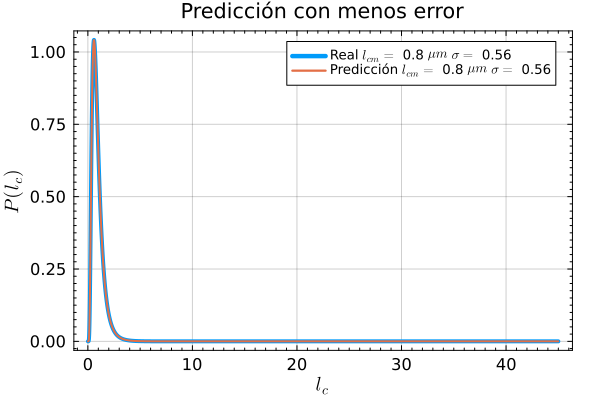

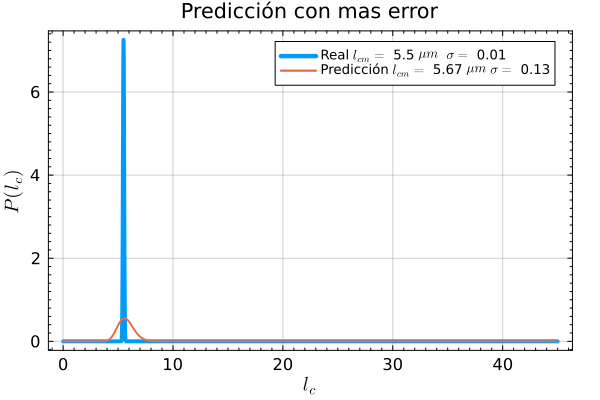

"C:\\Users\\Propietario\\OneDrive\\Escritorio\\ib\\Tesis_V1\\MLonNMR\\2-NNIdentificaHahn\\G_8.73e-7_TE_1_AE\\Plots\\worst.png"

In [21]:
# Evaluamos la red neuronal con los datos de testeo
best = 0
worst = 0
for i in 1:N_test
    if minimum(RMSE_scores_test) == RMSE_scores_test[i]
        println("El mínimo RMSE es $(RMSE_scores_test[i]) y se encuentra en la posición $i")
        best = i
    end
    if maximum(RMSE_scores_test) == RMSE_scores_test[i]
        println("El máximo RMSE es $(RMSE_scores_test[i]) y se encuentra en la posición $i")
        worst = i
    end
end

P_real_best = Pln.(dataparams_test[1,best], dataparams_test[2,best])
P_predict_best = Pln.(predictions_test[1,best], predictions_test[2,best])

P_real_worst = Pln.(dataparams_test[1,worst], dataparams_test[2,worst])
P_predict_worst = Pln.(predictions_test[1,worst], predictions_test[2,worst])

pl_best = Plots.plot(lcs, P_real_best, label = L"Real $l_{cm} = $" * " $(dataparams_test[1,best]) " * L"$\mu m$" * L" $σ = $" * " $(dataparams_test[2,best])", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_best, lcs, P_predict_best, label = L"Predicción $l_{cm} = $" * " $(round(predictions_test[1,best],digits = 2)) " * L"$\mu m$" * L" $σ =$" * " $(round(predictions_test[2,best],digits = 2))", title = "Predicción con menos error" , lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
display(pl_best)
Plots.savefig(pl_best, "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Plots/best.png")


pl_worst = Plots.plot(lcs, P_real_worst, label = L"Real $l_{cm} = $" * " $(dataparams_test[1,worst]) " * L"$\mu m$ " * L" $σ = $" * " $(dataparams_test[2,worst])", title = "Predicción con mas error" , xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_worst, lcs, P_predict_worst, label = L"Predicción $l_{cm} = $" * " $(round(predictions_test[1,worst],digits = 2)) " * L"$\mu m$" * L" $σ = $" * " $(round(predictions_test[2,worst],digits = 2))", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
display(pl_worst)
Plots.savefig(pl_worst, "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-NNIdentificaHahn/G_8.73e-7_TE_1_AE/Plots/worst.png")

In [28]:
all_signals = Float32.(Matrix(df_datasignals[:,1:3])')
all_dataparams = hcat(Float32.(df_datasignals[:,5]), Float32.(df_datasignals[:,4]))'

2×5600 adjoint(::Matrix{Float32}) with eltype Float32:
 0.5   0.5   0.5   0.5   0.5   0.5   …  6.0   6.0   6.0   6.0   6.0   6.0
 0.01  0.02  0.03  0.04  0.05  0.06     0.95  0.96  0.97  0.98  0.99  1.0

In [29]:
all_predictions = re(p)(all_signals)

2×5600 Matrix{Float32}:
 0.499469  0.499493   0.499491   0.499487   …  5.97656   5.97284   5.96889
 0.087712  0.0878751  0.0882581  0.0888227     0.975996  0.984726  0.993317

In [51]:
# Medidas de error globales
RMSE_total = RMSE(all_predictions, all_dataparams)

println("El error raíz cuadrática media de la red neuronal total es: $RMSE_total")

# Medidas de error puntuales
N_all = length(all_predictions[1,:])

RMSE_all = zeros(N_all)

for i in 1:N_all
    RMSE_all[i] = RMSE(all_predictions[:,i], all_dataparams[:,i])
end

El error raíz cuadrática media de la red neuronal total es: 0.01997189


In [52]:
RMSE_all_norm = RMSE_all ./ maximum(RMSE_all)

5600-element Vector{Float64}:
 0.3251957714098566
 0.28403322481320553
 0.24379218367605546
 0.20431129636065307
 0.16570781231164802
 0.12813479402677516
 0.09178850232788152
 0.05689802942450706
 0.023767695329836785
 0.007776161986418333
 ⋮
 0.026415097292899144
 0.03539557308336344
 0.04571562405451997
 0.057367462603412536
 0.070263325255537
 0.08429396235795698
 0.09950383985593123
 0.11576772780298372
 0.13315990879829603

In [53]:
# Plots de los errores de la predicion de la red
params_error = PlotlyJS.scatter(
    x = all_dataparams[1,1:end],
    y = all_dataparams[2,1:end],
    mode = "markers",
    hoverinfo = "text",
    hovertext = RMSE_all[1:end],
    marker = attr(
        color = RMSE_all[1:end],  # Use the color_vector for color mapping
        colorscale = "Hot",  # Choose a predefined colormap (e.g., "Viridis")
        colorbar_title = "RMSE",
    ),
)

params_layout = Layout(
    title = "Todos los datos",
    xaxis = attr(title = "lcm"),
    yaxis = attr(title = "σ"),
    font = attr(size = 15),
    width = 800,  # Set width (e.g., 600 pixels)
    height = 600, # Set height equal to width for a square plot
)

layout with fields font, height, margin, template, title, width, xaxis, and yaxis


In [54]:
params_plot = PlotlyJS.plot([params_error], params_layout)

┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means that you will not be able to save figures using `savefig`.
│ 
│ If you are on Windows this might be caused by known problems with Kaleido v0.2 on Windows (you are using version 0.2.1).
│ You might want to try forcing a downgrade of the Kaleido_jll library to 0.1.
│ Check the Package Readme at https://github.com/JuliaPlots/PlotlyKaleido.jl/tree/main#windows-note for more details.
│ 
│ If you think this is not your case, you might try using a longer timeout to check if the process is not responding (defaults to 10 seconds) by passing the desired value in seconds using the `timeout` kwarg when calling `PlotlyKaleido.start` or `PlotlyKaleido.restart`
└ @ PlotlyKaleido C:\Users\Propietario\.julia\packages\PlotlyKaleido\uMRVG\src\PlotlyKaleido.jl:24
┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means 

data: [
  "scatter with fields hoverinfo, hovertext, marker, mode, type, x, and y"
]

layout: "layout with fields font, height, margin, template, title, width, xaxis, and yaxis"